<a href="https://colab.research.google.com/github/SEC-API-io/sec-api-cookbook/blob/main/notebooks/form-c/form-c-tutorial-website.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Analysis of Crowdfunding Disclosures

This notebook illustrates how to perform exploratory data analysis on crowdfunding offering disclosures filed in SEC Form C.
Since 2016, these disclosures have been presented in XML format by companies. Utilizing our [Form C Crowdfunding API](https://sec-api.io/docs/form-c-crowdfunding-api), we convert the data to a standardized JSON format, making it available for detailed analysis.

Our analysis will focus on several key areas:

- Number of Form C disclosures made for the years from 2016 to 2024, per quarter, month and at what time of the day (pre-market, regular market, after-market)
- Distribution of disclosures across structured data fields, such as the proportion of disclosures by form type
- Offering amounts by number of filings and in time
- Annual Revenue of companies and ratio of offering amount to revenue


## Quick Start

To quickly retrieve data for a specific company, modify the following example as needed. For more detail, see [Form C Crowdfunding API](https://sec-api.io/docs/form-c-crowdfunding-api) and [sec-api-python package readme](https://github.com/janlukasschroeder/sec-api-python?tab=readme-ov-file#form-c-api---crowdfunding-campaigns).


In [1]:
%pip install sec_api # use %pip for reliable install in current environment

In [2]:
# NOTE: Replace with your own API key
API_KEY_SEC_API = "YOUR_API_KEY"

In [3]:
from sec_api import FormCApi
import json

formCApi = FormCApi(api_key=API_KEY_SEC_API)

search_params = {
    "query": "cik:1277575",
    "from": "0",
    "size": "1",
    "sort": [{"filedAt": {"order": "desc"}}],
}

# get C filing metadata: issuer background, offering details,
# financial information, and more
response = formCApi.get_data(search_params)
form_c_filing = response["data"]

print(json.dumps(form_c_filing, indent=2))

[
  {
    "id": "a515ea985770a6566b42de0fe6e6411d",
    "accessionNo": "0001818274-25-000005",
    "fileNo": "020-34763",
    "formType": "C/A",
    "filedAt": "2025-01-31T17:04:04-05:00",
    "cik": "1277575",
    "ticker": "SCGX",
    "companyName": "SAXON CAPITAL GROUP INC",
    "issuerInformation": {
      "isAmendment": false,
      "natureOfAmendment": "The issuer is extending their offering till April 1, 2025.",
      "issuerInfo": {
        "nameOfIssuer": "SAXON CAPITAL GROUP INC",
        "legalStatus": {
          "legalStatusForm": "Corporation",
          "jurisdictionOrganization": "NV",
          "dateIncorporation": "11-12-2003"
        },
        "issuerAddress": {
          "street1": "7740 E GRAY RD",
          "street2": "#103",
          "city": "SCOTTSDALE",
          "stateOrCountry": "AZ",
          "zipCode": "85260"
        },
        "issuerWebsite": "https://energyglasssolar.com/"
      },
      "isCoIssuer": false,
      "companyName": "PicMii Crowdfunding 

## Download Dataset

To load and prepare the dataset of over 30,000 proxy voting record disclosures from Form C in since 2016, we utilize the [Form C Proxy Voting Records API](https://sec-api.io/docs/form-c-crowdfunding-api). The following code handles data loading and preparation by executing multiple download processes in parallel, significantly reducing downloading time.

Once downloaded, all data objects are saved in JSONL format to `./form-c-dataset.jsonl`, which will serve as the dataset for the first part of the analysis.

Downloading the data may take several minutes.


In [4]:
import sys
import time
import random

# from multiprocessing import Pool # use in .py files only
from concurrent.futures import ThreadPoolExecutor

YEARS = range(2025, 2015, -1)  # from 2025 to 2016
TEMP_FILE_TEMPLATE = "./temp_file_form_c_{}.jsonl"
TARGET_FILE = "./form-c-dataset.jsonl"


def process_year(year):
    backoff_time = random.randint(10, 800) / 1000
    print(f"Starting year {year} with backoff time {backoff_time:,}s")
    sys.stdout.flush()
    time.sleep(backoff_time)

    tmp_filename = TEMP_FILE_TEMPLATE.format(year)
    tmp_file = open(tmp_filename, "a")

    for month in range(12, 0, -1):
        search_from = 0
        month_counter = 0

        while True:
            query = f"filedAt:[{year}-{month:02d}-01 TO {year}-{month:02d}-31]"
            searchRequest = {
                "query": query,
                "from": search_from,
                "size": "50",
                "sort": [{"filedAt": {"order": "desc"}}],
            }

            response = None
            try:
                response = formCApi.get_data(searchRequest)
            except Exception as e:
                print(f"{year}-{month:02d} error: {e}")
                sys.stdout.flush()
                continue

            if response == None or len(response["data"]) == 0:
                break

            search_from += 50
            month_counter += len(response["data"])
            jsonl_data = "\n".join([json.dumps(entry) for entry in response["data"]])
            tmp_file.write(jsonl_data + "\n")

        print(f"Finished loading {month_counter} Form C for {year}-{month:02d}")
        sys.stdout.flush()

    tmp_file.close()

    return year


if not os.path.exists(TARGET_FILE):
    with ThreadPoolExecutor(max_workers=4) as pool:
        processed_years = list(pool.map(process_year, YEARS))
    print("Finished processing all years.", processed_years)

    # merge the temporary files into one final file
    with open(TARGET_FILE, "a") as outfile:
        for year in YEARS:
            temp_file = TEMP_FILE_TEMPLATE.format(year)
            if os.path.exists(temp_file):
                with open(temp_file, "r") as infile:
                    outfile.write(infile.read())
else:
    print("File already exists. Skipping download.")

File already exists. Skipping download.


## Analyzing Data


In [5]:
# install all dependencies required for the notebook
%pip install -r requirements.txt

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as mtick
import seaborn as sns

style.use("default")

params = {
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "font.family": "sans-serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.color": "grey",
    "axes.grid": True,
    "axes.grid.axis": "y",
    "grid.alpha": 0.5,
    "grid.linestyle": ":",
}

plt.rcParams.update(params)

In [7]:
TARGET_FILE = "form-c-dataset.jsonl"
structured_data = pd.read_json(TARGET_FILE, lines=True)
structured_data = pd.json_normalize(structured_data.to_dict(orient="records"))

structured_data["filedAt"] = pd.to_datetime(structured_data["filedAt"], utc=True)
structured_data["filedAt"] = structured_data["filedAt"].dt.tz_convert("US/Eastern")
structured_data = structured_data.sort_values("filedAt", ascending=True).reset_index(
    drop=True
)
structured_data.drop_duplicates("accessionNo", keep="first", inplace=True)
structured_data["year"] = structured_data["filedAt"].dt.year
structured_data["month"] = structured_data["filedAt"].dt.month
structured_data["qtr"] = structured_data["month"].apply(lambda x: (x - 1) // 3 + 1)
structured_data["dayOfWeek"] = structured_data["filedAt"].dt.day_name()
# filedAtClass: preMarket (4:00AM-9:30AM), regularMarket (9:30AM-4:00PM), afterMarket (4:00PM-8:00PM)
structured_data["filedAtClass"] = structured_data["filedAt"].apply(
    lambda x: (
        "preMarket"
        if x.hour < 9 or (x.hour == 9 and x.minute < 30)
        else (
            "regularMarket"
            if x.hour < 16
            else "afterMarket" if x.hour < 20 else "other"
        )
    )
)

structured_data.head()

unique_years = structured_data["year"].nunique()
unique_companies = structured_data["cik"].nunique()
unique_filings = structured_data["accessionNo"].nunique()
min_year = structured_data["year"].min()
max_year = structured_data["year"].max()
max_year_full = max_year - 1  # to avoid incomplete data for the current year
print("Loaded dataframe with main documents of Form C Crowdfunding filings")
print(f"Number of filings: {unique_filings:,}")
print(f"Number of records: {len(structured_data):,}")
print(f"Number of years: {unique_years:,} ({min_year}-{max_year})")
print(f"Number of unique companies: {unique_companies:,}")

# structured_data.head()

Loaded dataframe with main documents of Form C Crowdfunding filings
Number of filings: 29,870
Number of records: 29,870
Number of years: 10 (2016-2025)
Number of unique companies: 8,041


In [8]:
structured_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29870 entries, 0 to 29869
Data columns (total 73 columns):
 #   Column                                                                  Non-Null Count  Dtype                     
---  ------                                                                  --------------  -----                     
 0   id                                                                      29870 non-null  object                    
 1   accessionNo                                                             29870 non-null  object                    
 2   fileNo                                                                  29870 non-null  object                    
 3   formType                                                                29870 non-null  object                    
 4   filedAt                                                                 29870 non-null  datetime64[ns, US/Eastern]
 5   cik                                           

In [9]:
structured_data_full_years = structured_data[
    structured_data["year"].between(min_year, max_year - 1)
]

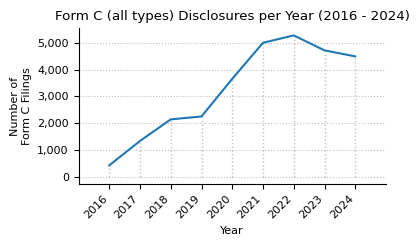

In [10]:
def plot_timeseries(ts, title):
    fig, ax = plt.subplots(figsize=(4, 2.5))
    ts["count"].plot(ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of\nForm C Filings")
    ax.set_xticks(np.arange(min_year, max_year, 1))
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    ax.set_xlim(min_year - 1, max_year)
    ax.grid(axis="x")
    ax.set_axisbelow(True)
    plt.xticks(rotation=45, ha="right")

    for year in range(min_year, max_year, 1):
        year_y_max = ts.loc[year, "count"]
        ax.vlines(year, 0, year_y_max, linestyles=":", colors="grey", alpha=0.5, lw=1)

    plt.tight_layout()
    plt.show()


form_c_counts = (
    structured_data_full_years.drop_duplicates(subset=["accessionNo"])
    .groupby(["year"])
    .size()
    .to_frame(name="count")
)

plot_timeseries(
    form_c_counts,
    title=f"Form C (all types) Disclosures per Year ({min_year} - {max_year_full})",
)

In [11]:
count_formType = (
    structured_data_full_years.drop_duplicates(subset=["accessionNo"])
    .groupby(["formType"])
    .size()
    .sort_values(ascending=False)
    .to_frame(name="Count")
).rename_axis("Submission Type")
count_formType["Pct"] = (
    count_formType["Count"].astype(int) / count_formType["Count"].astype(int).sum()
).map("{:.0%}".format)
count_formType["Count"] = count_formType["Count"].map(lambda x: f"{x:,}")

print(f"Form C Disclosures by Submission Type ({min_year} - {max_year_full})")
count_formType

Form C Disclosures by Submission Type (2016 - 2024)


,Count,Pct
Submission Type,,
C/A,"10,065",34%
C,"9,461",32%
C-U,"4,593",16%
C-AR,"3,911",13%
C-W,979,3%
C-AR/A,251,1%
C/A-W,28,0%
C-U-W,22,0%
C-TR-W,18,0%


In [12]:
form_c_counts_by_type = (
    structured_data_full_years.drop_duplicates(subset=["accessionNo"])
    .groupby(["year", "formType"])
    .size()
    .to_frame(name="count")
    .unstack(fill_value=0)
)

form_c_counts_by_type.loc["Total"] = form_c_counts_by_type.sum()
form_c_counts_by_type["Total"] = form_c_counts_by_type.sum(axis=1)


print(f"Form C counts from {min_year} to {max_year_full}.")
form_c_counts_by_type

Form C counts from 2016 to 2024.


count                                                           Total
formType     C  C-AR C-AR-W C-AR/A C-TR-W   C-U C-U-W  C-W    C/A C/A-W       
year                                                                          
2016       192     0      0      0      0    35     0   15    173     4    419
2017       524    59      0      9      0   198     1   45    494     3   1333
2018       763   218      3     16      1   366     2   54    718     1   2142
2019       717   324      1     11      0   345     1   67    785     0   2251
2020      1164   436      1     14      1   402     2  135   1504     2   3661
2021      1582   513      0    101      2   772     3  198   1834     7   5012
2022      1601   784      1     28      2  1030    10  218   1609     6   5289
2023      1479   842      3     35      5   799     0  139   1425     1   4728
2024      1439   735      0     37      7   646     3  108   1523     4   4502
Total     9461  3911      9    251     18  4593    22  979  10065    28  29337

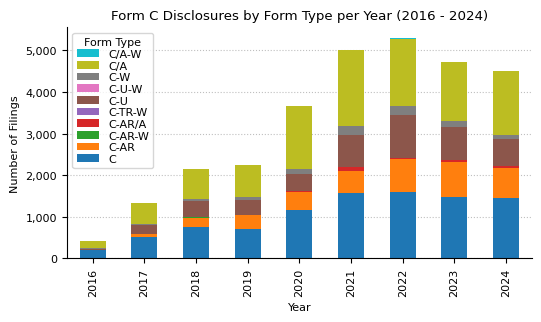

In [13]:
fig, ax = plt.subplots(figsize=(6, 3))
form_c_counts_by_type["count"].drop("Total").plot(kind="bar", stacked=True, ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Number of Filings")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    list(reversed(handles)),
    list(reversed(labels)),
    title="Form Type",
    labelspacing=0.15,
)
ax.set_title(f"Form C Disclosures by Form Type per Year ({min_year} - {max_year_full})")
plt.show()

In [14]:
counts_qtr_yr_piv = (
    structured_data_full_years.groupby(["year", "qtr"]).size().unstack().fillna(0)
).astype(int)

print(f"Form C (all types) counts by quarter from {min_year} to {max_year_full}.")
counts_qtr_yr_piv.T

Form C (all types) counts by quarter from 2016 to 2024.


year,2016,2017,2018,2019,2020,2021,2022,2023,2024
qtr,,,,,,,,,
1,0,198,407,474,633,1071,1124,1109,964
2,76,382,752,718,1120,1612,1870,1679,1667
3,147,322,499,477,900,1155,1167,929,890
4,196,431,484,582,1008,1174,1128,1011,981


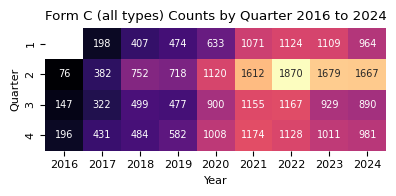

In [15]:
plt.figure(figsize=(4, 2))
sns.heatmap(
    counts_qtr_yr_piv.T,
    annot=True,  # Display the cell values
    fmt="d",  # Integer formatting
    cmap="magma",  # Color map
    cbar_kws={"label": "Count"},  # Colorbar label
    mask=counts_qtr_yr_piv.T == 0,  # Mask the cells with value 0
    cbar=False,
    annot_kws={"fontsize": 7},
)
plt.grid(False)
plt.title(f"Form C (all types) Counts by Quarter {min_year} to {max_year_full}")
plt.xlabel("Year")
plt.ylabel("Quarter")
plt.tight_layout()
plt.show()

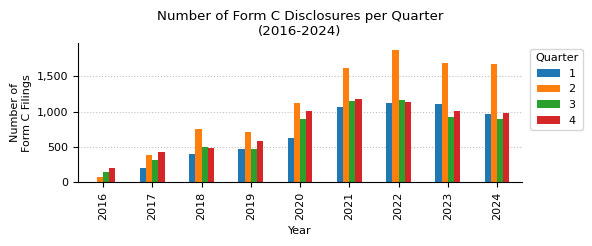

In [16]:
counts_qtr_yr = counts_qtr_yr_piv.stack().reset_index(name="count")

fig, ax = plt.subplots(figsize=(6, 2.5))
counts_qtr_yr_piv.plot(kind="bar", ax=ax, legend=True)
ax.legend(title="Quarter", loc="upper right", bbox_to_anchor=(1.15, 1))
ax.set_title(f"Number of Form C Disclosures per Quarter\n({min_year}-{max_year_full})")
ax.set_xlabel("Year")
ax.set_ylabel("Number of\nForm C Filings")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

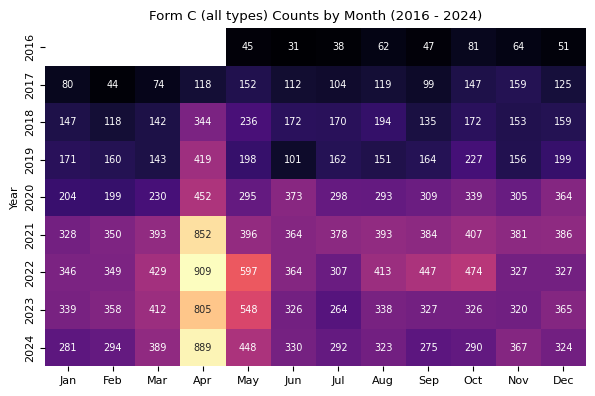

In [17]:
counts_month_yr_piv = (
    structured_data_full_years.groupby(["year", "month"]).size().unstack().fillna(0)
).astype(int)

plt.figure(figsize=(6, 4))
sns.heatmap(
    counts_month_yr_piv,
    annot=True,
    fmt="d",
    cmap="magma",
    cbar_kws={"label": "Count"},
    mask=counts_month_yr_piv == 0,
    cbar=False,
    annot_kws={"size": 7},
)
# convert x-labels to month names: 1 => Jan, 2 => Feb, etc.
plt.xticks(
    ticks=np.arange(0.5, 12.5, 1),
    labels=[pd.to_datetime(str(i), format="%m").strftime("%b") for i in range(1, 13)],
)
plt.grid(False)
plt.title(f"Form C (all types) Counts by Month ({min_year} - {max_year_full})")
plt.xlabel("")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

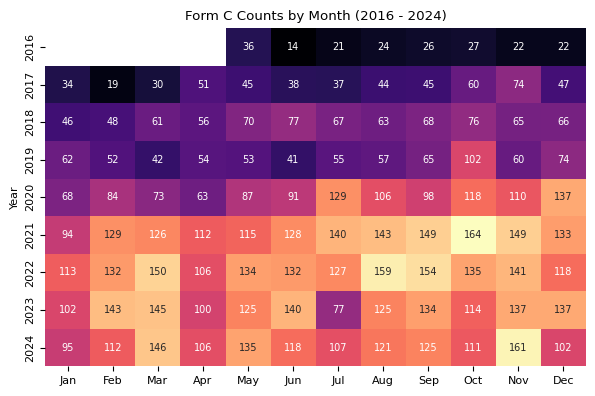

In [18]:
counts_c_only_month_yr_piv = (
    structured_data_full_years[structured_data_full_years["formType"] == "C"]
    .groupby(["year", "month"])
    .size()
    .unstack()
    .fillna(0)
).astype(int)

plt.figure(figsize=(6, 4))
sns.heatmap(
    counts_c_only_month_yr_piv,
    annot=True,
    fmt="d",
    cmap="magma",
    cbar_kws={"label": "Count"},
    mask=counts_c_only_month_yr_piv == 0,
    cbar=False,
    annot_kws={"size": 7},
)
# convert x-labels to month names: 1 => Jan, 2 => Feb, etc.
plt.xticks(
    ticks=np.arange(0.5, 12.5, 1),
    labels=[pd.to_datetime(str(i), format="%m").strftime("%b") for i in range(1, 13)],
)
plt.grid(False)
plt.title(f"Form C Counts by Month ({min_year} - {max_year_full})")
plt.xlabel("")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

In [19]:
print(
    f"Descriptive statistics for Form C counts by month from {min_year} to {max_year_full}."
)
month_stats = (
    counts_c_only_month_yr_piv.loc[2004:]
    .describe(percentiles=[0.025, 0.975])
    .round(0)
    .astype(int)
)
month_stats

Descriptive statistics for Form C counts by month from 2016 to 2024.


month,1,2,3,4,5,6,7,8,9,10,11,12
count,9,9,9,9,9,9,9,9,9,9,9,9
mean,68,80,86,72,89,87,84,94,96,101,102,93
std,37,52,57,37,40,47,43,48,47,41,48,42
min,0,0,0,0,36,14,21,24,26,27,22,22
2.5%,7,4,6,10,38,19,24,28,30,34,30,27
50%,68,84,73,63,87,91,77,106,98,111,110,102
97.5%,111,141,149,111,135,138,138,156,153,158,159,137
max,113,143,150,112,135,140,140,159,154,164,161,137


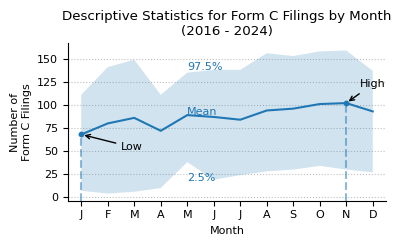

In [20]:
def plot_box_plot_as_line(
    data: pd.DataFrame,
    x_months=True,
    title="",
    x_label="",
    x_pos_mean_label=2,
    pos_labels=None,
    pos_high_low=None,
    y_label="",
    y_formatter=lambda x, p: "{:.0f}".format(int(x) / 1000),
    show_high_low_labels=True,
    show_inline_labels=True,
    show_bands=True,
    figsize=(4, 2.5),
    line_source="mean",
):
    fig, ax = plt.subplots(figsize=figsize)

    line_to_plot = data[line_source]
    lower_label = "2.5%"
    upper_label = "97.5%"
    lower = data[lower_label]
    upper = data[upper_label]

    line_to_plot.plot(ax=ax)

    if show_bands:
        ax.fill_between(line_to_plot.index, lower, upper, alpha=0.2)

    if x_months:
        ax.set_xlim(0.5, 12.5)
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

    ax.yaxis.set_major_formatter(mtick.FuncFormatter(y_formatter))
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

    ymin, ymax = ax.get_ylim()
    y_scale = ymax - ymin

    max_x = int(line_to_plot.idxmax())
    max_y = line_to_plot.max()
    min_x = int(line_to_plot.idxmin())
    min_y = line_to_plot.min()

    ax.axvline(
        max_x,
        ymin=0,
        ymax=((max_y - ymin) / (ymax - ymin)),
        linestyle="dashed",
        color="tab:blue",
        alpha=0.5,
    )
    ax.scatter(max_x, max_y, color="tab:blue", s=10)
    ax.axvline(
        min_x,
        ymin=0,
        ymax=((min_y - ymin) / (ymax - ymin)),
        linestyle="dashed",
        color="tab:blue",
        alpha=0.5,
    )
    ax.scatter(min_x, min_y, color="tab:blue", s=10)

    x_pos_mean_label_int = int(x_pos_mean_label)
    if show_inline_labels:
        mean_x = x_pos_mean_label
        mean_y = line_to_plot.iloc[x_pos_mean_label_int] * 1.02
        upper_x = x_pos_mean_label
        upper_y = upper.iloc[x_pos_mean_label_int]
        lower_x = x_pos_mean_label
        lower_y = lower.iloc[x_pos_mean_label_int] * 0.95

        if pos_labels:
            mean_x = pos_labels["mean"]["x"]
            mean_y = pos_labels["mean"]["y"]
            upper_x = pos_labels["upper"]["x"]
            upper_y = pos_labels["upper"]["y"]
            lower_x = pos_labels["lower"]["x"]
            lower_y = pos_labels["lower"]["y"]

        ax.text(mean_x, mean_y, "Mean", color="tab:blue", fontsize=8)
        ax.text(upper_x, upper_y, upper_label, color="tab:blue", fontsize=8)
        ax.text(lower_x, lower_y, lower_label, color="tab:blue", fontsize=8)

    if show_high_low_labels:
        high_x_origin = max_x
        high_y_origin = max_y
        high_x_label = high_x_origin + 0.5
        high_y_label = high_y_origin + 0.1 * y_scale
        if pos_high_low:
            high_x_label = pos_high_low["high"]["x"]
            high_y_label = pos_high_low["high"]["y"]
        ax.annotate(
            "High",
            (high_x_origin, high_y_origin),
            xytext=(high_x_label, high_y_label),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

        low_x_origin = min_x * 1.01
        low_y_origin = min_y
        low_x_label = low_x_origin + 1.5
        low_y_label = low_y_origin - 0.1 * y_scale
        if pos_high_low:
            low_x_label = pos_high_low["low"]["x"]
            low_y_label = pos_high_low["low"]["y"]
        ax.annotate(
            "Low",
            (low_x_origin, low_y_origin),
            xytext=(low_x_label, low_y_label),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

    ax.grid(axis="x")
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()


plot_box_plot_as_line(
    data=month_stats.T,
    title=f"Descriptive Statistics for Form C Filings by Month\n({min_year} - {max_year_full})",
    x_label="Month",
    y_label="Number of\nForm C Filings",
    y_formatter=lambda x, p: "{:.0f}".format(int(x)),
    x_pos_mean_label=5,
)

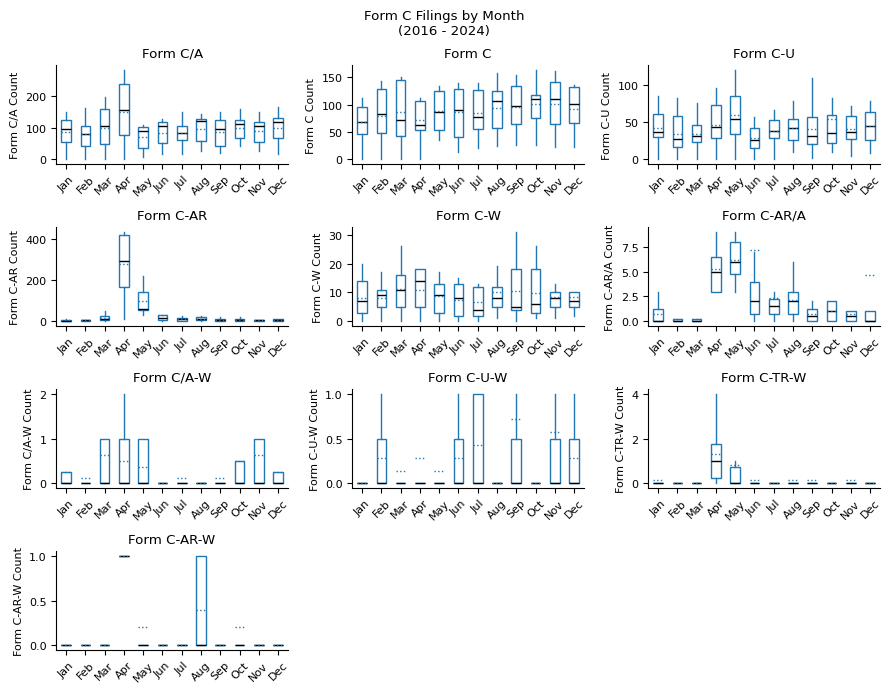

In [21]:
form_types = count_formType.index.tolist()

fig, axes = plt.subplots(4, 3, figsize=(9, 7))

cnt = 0
for formType in form_types:

    data = (
        structured_data_full_years[structured_data_full_years["formType"] == formType]
        .groupby(["year", "month"])
        .size()
        .unstack()
        .fillna(0)
        .reindex(columns=range(1, 13), fill_value=0)  # ensure all month are included
    )

    # if data.sum().sum() < 100:
    #     continue

    ax = axes.flatten()[cnt]
    cnt += 1
    try:
        data.boxplot(
            ax=ax,
            grid=False,
            showfliers=False,
            flierprops=dict(marker="o", markersize=3),
            patch_artist=True,
            boxprops=dict(facecolor="white", color="tab:blue"),
            showmeans=True,
            meanline=True,
            meanprops={"color": "tab:blue", "linestyle": ":"},
            medianprops={"color": "black"},
            capprops={"color": "none"},
        )

        ax.set_title(f"Form {formType}")
        ax.set_xlabel("")
        ax.set_ylabel(f"Form {formType} Count")
        xticklabels = [
            pd.to_datetime(str(x), format="%m").strftime("%b") for x in range(1, 13)
        ]
        ax.set_xticklabels(xticklabels)
        ax.tick_params(axis="x", rotation=45)
    except Exception as e:
        print(f"Error: {e}")

# disable the empty subplots
for i in range(cnt, 12):
    axes.flatten()[i].axis("off")

fig.suptitle(f"Form C Filings by Month\n({min_year} - {max_year_full})")
plt.tight_layout()
plt.show()

In [22]:
counts_per_month_by_formType = (
    structured_data[["year", "month", "accessionNo", "formType"]]
    .groupby(["year", "month", "formType"])
    .count()
    .rename(columns={"accessionNo": "count"})
    .pivot_table(
        index=["year", "month"],  # Rows
        columns="formType",  # Columns
        values="count",  # Values to fill
        fill_value=0,  # Replace NaN with 0
    )
    .astype(int)
    .reset_index()  # Make year and month normal columns
)

counts_per_month_by_formType

formType,year,month,C,C-AR,C-AR-W,C-AR/A,C-TR-W,C-U,C-U-W,C-W,C/A,C/A-W
0,2016,5,36,0,0,0,0,0,0,0,9,0
1,2016,6,14,0,0,0,0,0,0,1,16,0
2,2016,7,21,0,0,0,0,0,0,0,17,0
3,2016,8,24,0,0,0,0,10,0,2,26,0
4,2016,9,26,0,0,0,0,2,0,0,19,0
...,...,...,...,...,...,...,...,...,...,...,...,...
101,2024,10,111,18,0,2,0,35,0,3,121,0
102,2024,11,161,13,0,3,1,69,0,3,116,1
103,2024,12,102,11,0,1,0,79,1,7,123,0
104,2025,1,101,13,0,0,0,71,0,2,118,0


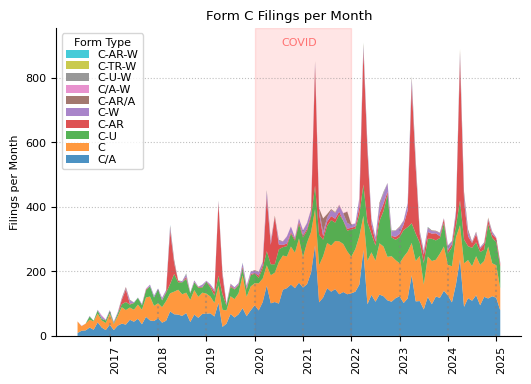

In [23]:
fix, ax = plt.subplots(figsize=(6, 4))

ax.stackplot(
    counts_per_month_by_formType["year"].astype(str)
    + "-"
    + counts_per_month_by_formType["month"].astype(str),
    *[counts_per_month_by_formType[ft] for ft in form_types],
    labels=[f"{ft}" for ft in form_types],
    alpha=0.8,
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    list(reversed(handles)),
    list(reversed(labels)),
    title="Form Type",
    labelspacing=0.15,
)

ax.set_title("Form C Filings per Month")
ax.set_ylabel("Filings per Month")
xticks = (
    counts_per_month_by_formType["year"].astype(str)
    + "-"
    + counts_per_month_by_formType["month"].astype(str)
)
ax.set_xticks([i for i, x in enumerate(xticks) if x.endswith("-1")])
ax.set_xticklabels(
    [label.get_text()[:4] for label in ax.get_xticklabels()], rotation=90, ha="left"
)

ax.grid(axis="y", linestyle=":", alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# draw vertical lines for each first month of the year, dotted, transparency 0.5,
# with height of the y value for the respective month
for year, month in counts_per_month_by_formType[["year", "month"]].values:
    if month == 1:
        ax.vlines(
            f"{year}-{month}",
            ymin=0,
            ymax=counts_per_month_by_formType[
                (counts_per_month_by_formType["year"] == year)
                & (counts_per_month_by_formType["month"] == month)
            ]
            .drop(columns=["year", "month"])
            .sum(axis=1),
            linestyle=":",
            alpha=0.5,
            color="grey",
        )

ax.axvspan("2020-1", "2022-1", alpha=0.1, color="red", zorder=-100)
ax.text(
    "2020-12",
    ax.get_ylim()[1] - 45,
    "COVID",
    horizontalalignment="center",
    verticalalignment="center",
    color="red",
    alpha=0.5,
)
plt.show()

In [24]:
counts_filedAtClass = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["filedAtClass"])
    .size()
    .sort_values(ascending=False)
    .to_frame(name="Count")
).rename_axis("Publication Time")
counts_filedAtClass["Pct"] = (
    counts_filedAtClass["Count"].astype(int)
    / counts_filedAtClass["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_filedAtClass["Count"] = counts_filedAtClass["Count"].map(lambda x: f"{x:,}")
counts_filedAtClass.index = (
    counts_filedAtClass.index.str.replace("preMarket", "Pre-Market (4:00 - 9:30 AM)")
    .str.replace("marketHours", "Market Hours (9:30 AM - 4:00 PM)")
    .str.replace("afterMarket", "After Market (4:00 - 8:00 PM)")
)
counts_filedAtClass = counts_filedAtClass.reindex(counts_filedAtClass.index[::-1])

print(
    f"Form counts by pre-market, regular market hours,\nand after-market publication time ({min_year} - {max_year_full})."
)
counts_filedAtClass

Form counts by pre-market, regular market hours,
and after-market publication time (2016 - 2024).


,Count,Pct
Publication Time,,
Pre-Market (4:00 - 9:30 AM),"1,346",5%
other,"2,273",8%
After Market (4:00 - 8:00 PM),"10,044",34%
regularMarket,"16,207",54%


In [25]:
counts_dayOfWeek = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["dayOfWeek"])
    .size()
    .to_frame(name="Count")
).rename_axis("Day of the Week")
counts_dayOfWeek["Pct"] = (
    counts_dayOfWeek["Count"].astype(int) / counts_dayOfWeek["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_dayOfWeek["Count"] = counts_dayOfWeek["Count"].map(lambda x: f"{x:,}")

print(f"Form C disclosures by day of the week ({min_year} - {max_year}).")
counts_dayOfWeek.loc[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]]

Form C disclosures by day of the week (2016 - 2025).


,Count,Pct
Day of the Week,,
Monday,"5,788",19%
Tuesday,"5,926",20%
Wednesday,"5,399",18%
Thursday,"5,757",19%
Friday,"7,000",23%


## Offering amounts

In this section, we analyze the offering amount in the initial Form C filings.


In [26]:
form_c = structured_data_full_years[structured_data_full_years["formType"] == "C"]

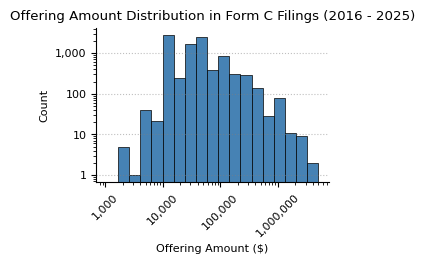

In [27]:
data = form_c["offeringInformation.offeringAmount"]
data = data[data > 1000]

# Define log-spaced bins
bin_edges = np.logspace(np.log10(min(data)), np.log10(max(data)), num=20)

fig, ax = plt.subplots(figsize=(3, 2))
ax.hist(
    data,
    bins=bin_edges,
    color="steelblue",
    edgecolor="black",
    linewidth=0.5,
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.tick_params(axis="x", rotation=45)
ax.set_title(
    f"Offering Amount Distribution in Form C Filings ({min_year} - {max_year})"
)
ax.set_xlabel("Offering Amount ($)")
ax.set_ylabel("Count")
plt.show()

In [28]:
offering_amounts = (
    form_c[["accessionNo", "fileNo", "year", "offeringInformation.offeringAmount"]]
    .drop_duplicates(subset=["accessionNo", "fileNo"])
    .groupby(["year"])
    .sum()["offeringInformation.offeringAmount"]
)

# offering_amounts.loc["Total"] = offering_amounts.sum()

print(f"Offering Amount in Form C filings from {min_year} to {max_year_full}.")
offering_amounts

Offering Amount in Form C filings from 2016 to 2024.


year
2016    2.226972e+07
2017    3.883646e+07
2018    4.759816e+07
2019    4.217072e+07
2020    6.845360e+07
2021    1.312889e+08
2022    1.323496e+08
2023    1.038922e+08
2024    1.076026e+08
Name: offeringInformation.offeringAmount, dtype: float64

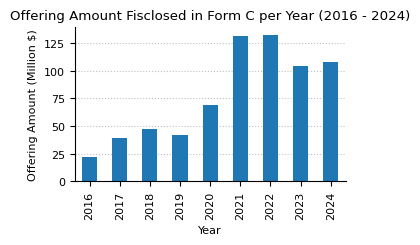

In [29]:
fig, ax = plt.subplots(figsize=(3.5, 2))
offering_amounts.apply(lambda x: x / 1e6).plot(kind="bar", stacked=True, ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Offering Amount (Million $)")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
ax.set_title(
    f"Offering Amount Fisclosed in Form C per Year ({min_year} - {max_year_full})"
)
plt.show()

## Annual Revenue of Offering Company


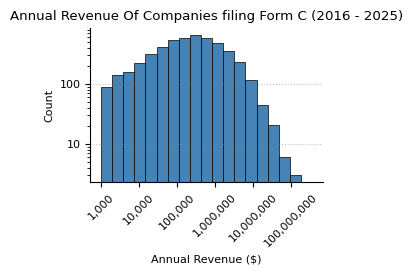

In [30]:
data = form_c["annualReportDisclosureRequirements.revenueMostRecentFiscalYear"]
data = data[data > 1000]

# Define log-spaced bins
bin_edges = np.logspace(np.log10(min(data)), np.log10(max(data)), num=20)

fig, ax = plt.subplots(figsize=(3, 2))
ax.hist(
    data,
    bins=bin_edges,
    color="steelblue",
    edgecolor="black",
    linewidth=0.5,
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.tick_params(axis="x", rotation=45, which="major")
ax.tick_params(axis="x", which="minor", bottom=False)
ax.set_title(f"Annual Revenue Of Companies filing Form C ({min_year} - {max_year})")
ax.set_xlabel("Annual Revenue ($)")
ax.set_ylabel("Count")
plt.show()

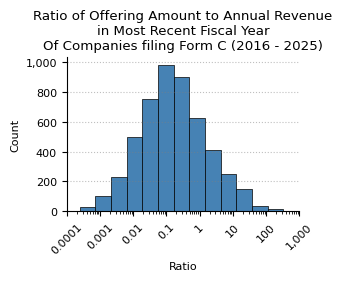

In [31]:
ratio_df = form_c[
    (form_c["annualReportDisclosureRequirements.revenueMostRecentFiscalYear"] > 1000)
    & (form_c["annualReportDisclosureRequirements.revenueMostRecentFiscalYear"] > 1000)
]

data = (
    ratio_df["offeringInformation.offeringAmount"]
    / ratio_df["annualReportDisclosureRequirements.revenueMostRecentFiscalYear"]
)

bin_edges = np.logspace(np.log10(min(data)), np.log10(max(data)), num=20)

fig, ax = plt.subplots(figsize=(3, 2))
ax.hist(
    data,
    bins=bin_edges,
    color="steelblue",
    edgecolor="black",
    linewidth=0.5,
)
ax.set_xscale("log")


def dynamic_formatter(x, pos):
    """Formats numbers dynamically: only use necessary decimal places"""
    return f"{x:,.6g}"  # Uses up to 6 significant digits, removing trailing zeros


ax.xaxis.set_major_formatter(mtick.FuncFormatter(dynamic_formatter))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.tick_params(axis="x", rotation=45)
ax.set_xlim(0.0001, 1000)

ax.set_title(
    f"Ratio of Offering Amount to Annual Revenue"
    "\nin Most Recent Fiscal Year"
    f"\nOf Companies filing Form C ({min_year} - {max_year})"
)
ax.set_xlabel("Ratio")
ax.set_ylabel("Count")
plt.show()